# Fully Convolutional Networks for Semantic Segmentation

Using the model from https://gist.github.com/shelhamer/91eece041c19ff8968ee


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import os
import sys
caffe_root = os.environ['CAFFE_ROOT']  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [5]:
caffe.set_mode_cpu()

net_root = '../fcn-8s'

model_def = net_root + '/deploy.prototxt'
model_weights = net_root + '/trained-weights.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing.

  The input is expected in BGR channel order, with the following per-channel mean subtracted:
  B 104.00698793 G 116.66876762 R 122.67891434
  
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [8]:
mu = np.array([104.00698793, 116.66876762, 122.67891434])
print 'mean values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean values: [('B', 104.00698792999999), ('G', 116.66876762), ('R', 122.67891434000001)]


### 3. CPU segmentation

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

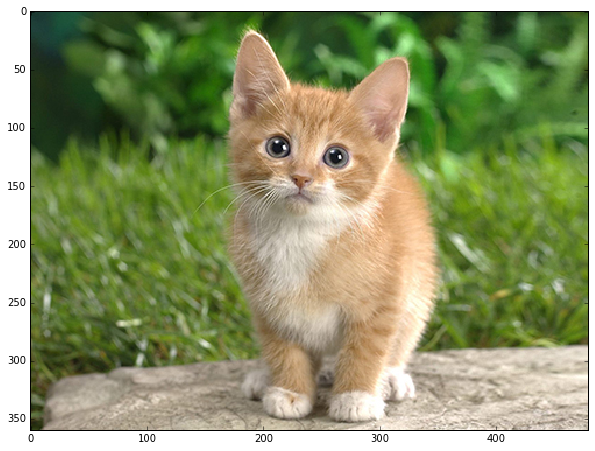

In [44]:
image = caffe.io.load_image(caffe_root + '/examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

* Adorable! Let's classify it!

In [45]:
### perform classification
output = net.forward()

score = output['score'][0]  # the output probability vector for the first image in the batch

print 'score:', score

score: [[[  1.30957895e-04   3.92873684e-04   6.54789503e-04 ...,   3.74107808e-02
     3.74078862e-02   3.74049954e-02]
  [  3.92873684e-04   1.17862108e-03   1.96436839e-03 ...,   1.12232342e-01
     1.12223670e-01   1.12214983e-01]
  [  6.54789503e-04   1.96436839e-03   3.27394740e-03 ...,   1.87053904e-01
     1.87039435e-01   1.87024981e-01]
  ..., 
  [  1.70096569e-02   5.10289744e-02   8.50482881e-02 ...,   6.96380138e+00
     6.86674070e+00   6.76967955e+00]
  [  1.69872679e-02   5.09618074e-02   8.49363431e-02 ...,   6.93449402e+00
     6.83500528e+00   6.73551655e+00]
  [  1.69648789e-02   5.08946404e-02   8.48243982e-02 ...,   6.90518570e+00
     6.80327034e+00   6.70135403e+00]]

 [[ -2.71926183e-06  -8.15778549e-06  -1.35963091e-05 ...,  -1.09280460e-02
    -1.09014250e-02  -1.08748041e-02]
  [ -8.15778549e-06  -2.44733565e-05  -4.07889274e-05 ...,  -3.27841379e-02
    -3.27042714e-02  -3.26244086e-02]
  [ -1.35963091e-05  -4.07889274e-05  -6.79815421e-05 ...,  -5.46402261

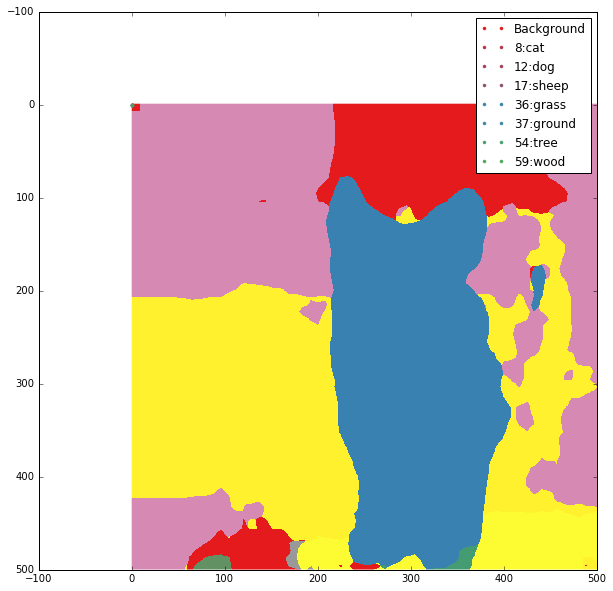

In [47]:
painted = np.argmax(score, axis=0)

cmap = plt.cm.get_cmap('Set1')
plt.imshow(painted, cmap=cmap)

names = dict()
lines = open(net_root + '/legend.txt').readlines()
for line in map(lambda x: x.split(':'), lines):
    names[int(line[0])] = line[0] + ':' + line[1].strip()
names[0] = "Background"
for entry in np.unique(painted):
    mycolor = cmap(entry)
    plt.plot(0, 0, ".", c=mycolor, label=names[entry])

plt.legend()